In [8]:
# download mnist dataset
import torch
from torchvision.datasets import MNIST
from torch import nn
from torch.nn import functional as F

mnist = MNIST(root='./data', download=True)

In [9]:
mnist.data.shape

torch.Size([60000, 28, 28])

# Question 1:

## 1 a). 
The problem involved creating a linear model with logistic activation that performs the binary classification whether an image is a ‘4’. To this end, my first attempt involved a simple linear layer trained using the mse loss. Since there are 60000 images in the training set, I decided to split them into 50000, 10000 train and validation sets. A mini-batch SGD is employed for better convergence. 

However during the training process, I encountered an issue that leads the model into predicting every image to 0, or 'not 4', while still able to attain good mse on the testing set. This happens because the dataset itself is inbalanced, where the number of '4' only accounted around 1/10 of the entire dataset. To address this, I decreased the learning rate and introduced sample weight when calculating MSE. By doing that, the model is able to pick up useful features for this binary classification task. 


In [10]:
class Model1(nn.Module):
    # this is supposed to be a linear model
    def __init__(self):
        super(Model1, self).__init__()
        self.input = nn.Flatten()
        self.linear = nn.Linear(28*28, 1) # one probability telling whether the image is '4'
        
    def forward(self, x):
        x = self.input(x)
        x = self.linear(x)
        x = F.sigmoid(x)
        return x


In [11]:
(mnist.test_labels == 4).float().mean()

tensor(0.0974)

Training: 100%|██████████| 31250/31250 [00:18<00:00, 1710.51it/s]


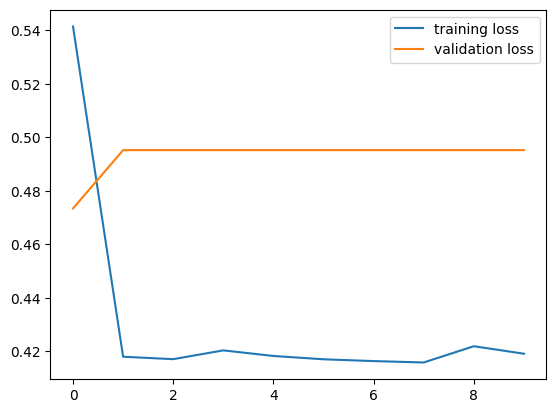

In [12]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

model1 = Model1()

def train_model(model, epochs=100):

    optimizer = torch.optim.SGD(model.parameters(), lr=0.0003)
    # training loop
    # split training into train and validation
    train_X = mnist.data[:50000]
    train_y = mnist.targets[:50000]
    valid_X = mnist.data[50000:]
    valid_y = mnist.targets[50000:]



    # print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)
    # probability transformation of the target
    train_y = (train_y == 4).float().reshape(-1, 1)
    valid_y = (valid_y == 4).float().reshape(-1, 1)
    training_loss = []
    validation_loss = []

    dl = DataLoader(list(zip(train_X, train_y)), batch_size=16, shuffle=True)

    pbar = tqdm(total=epochs * len(dl), desc='Training')

    val_weight = torch.zeros(valid_y.shape)
    val_weight[valid_y == 1] = 0.9
    val_weight[valid_y == 0] = 0.1
    for epoch in tqdm(range(epochs)):
        loss_batch = torch.zeros(len(dl))
        optimizer.zero_grad()
        for i, batch in enumerate(dl):
            train_X, train_y = batch
            y_pred = model(train_X.float())
            weight = torch.zeros(y_pred.shape)
            weight[train_y == 1] = 0.9
            weight[train_y == 0] = 0.1
            loss = F.mse_loss(y_pred, train_y, weight=weight)
            # balance the dataset
            loss.backward()
            pbar.update(1)
            loss_batch[i] = loss.detach().item()
            
        validation_loss.append(F.mse_loss(model(valid_X.float()), valid_y, weight=val_weight).detach().item())
        training_loss.append(loss_batch.mean().detach().item())
        optimizer.step()

    pbar.close()

    return training_loss, validation_loss

training_loss, validation_loss = train_model(model1, epochs=10)


plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()


In [15]:
W = model1.linear.weight

In [16]:
# test mse
test_X = mnist.test_data
test_y = mnist.test_labels
test_y = (test_y == 4).float()

test_y_pred = model1(test_X.float())
test_loss = F.mse_loss(test_y_pred, test_y)
test_acc = ((test_y_pred > 0.5) == test_y).float().mean()
print(test_loss, test_acc)

/tmp/ipykernel_95182/1170051993.py:7: UserWarning: Using a target size (torch.Size([60000])) that is different to the input size (torch.Size([60000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss = F.mse_loss(test_y_pred, test_y)


RuntimeError: [enforce fail at alloc_cpu.cpp:118] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 14400000000 bytes. Error code 12 (Cannot allocate memory)

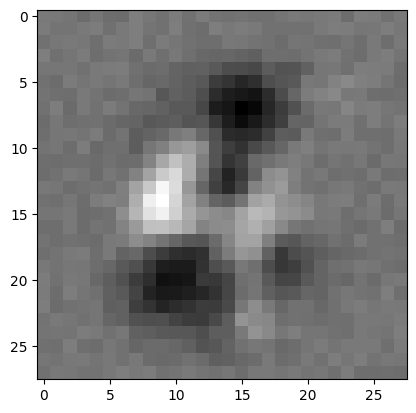

In [ ]:
# %matplotlib QtAgg
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(W.detach().numpy().reshape(28, 28), cmap='gray')

## 1. b).
My model's test performance is 0.2088 when calculating MSE, and attains a 0.7910 accuracy when cutting-off at 0.5. Throughout the training process, the training loss and validation loss both decreased. 
By visualizing `W`, we also see there's a brighter spot that takes the shape of '4' where its darker in which areas that are seen in other numbers like '6' or '8' but not '4'. 

# Question 2

## 2 a).

This task involves creating a three layer perceptron with linear layers A, B, and w; performing the same task as the previous question, and employs a sigmoid function in the end. The exact same training strategy is used as the previous model, including validation set and weighted MSE loss. The dimensions `d1` and `d2` are chosen using experience and tuned during training. `d1` was chosen to be 196, trying to reach a 14*14 feature from the original 28*28 image; and d2 was chosen to be 14 to impose lower  rank since the B and W layers can be practically combined. 

ReLU function is employed for the A linear layer due to its simplicity and tendency to preserve gradient. 
Note that the two-layer model also suffers from the tendency to output 0 regardless of the input, and more careful tuning on the parameters is often required

In [ ]:
class Model2(nn.Module):

    def __init__(self, d1, d2):
        super(Model2, self).__init__()
        self.input = nn.Flatten()
        self.A = nn.Linear(28*28, d1, bias=True)
        self.B = nn.Linear(d1, d2, bias=False)
        self.W = nn.Linear(d2, 1, bias=True)

    def forward(self, x):
        x = self.input(x)
        x = self.A(x)
        x = F.relu(x)
        z = self.B(x)
        # z = F.relu(z)
        y = self.W(z)
        y = F.sigmoid(y)
        return y
    


        

Training: 100%|██████████| 31250/31250 [00:12<00:00, 2408.81it/s]


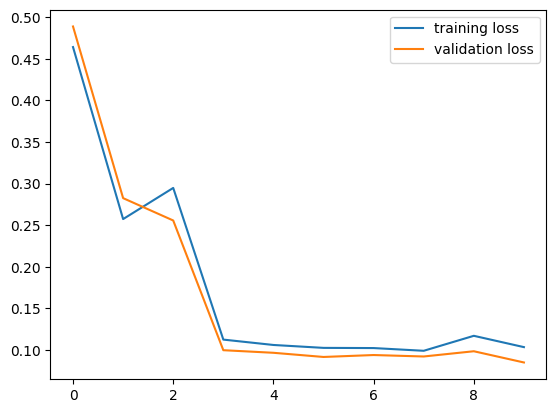

In [ ]:

model2 = Model2(196, 14)
training_loss, validation_loss = train_model(model2, epochs=10)

plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()

In [ ]:
# test mse
test_X = mnist.test_data
test_y = mnist.test_labels
test_y = (test_y == 4).float()

test_y_pred = model2(test_X.float())
test_loss = F.mse_loss(test_y_pred, test_y)
test_acc = ((test_y_pred > 0.5) == test_y).float().mean()

print(test_loss, test_acc)

/var/folders/v9/h59kc0b515b1kkq2j6zz8pbm0000gn/T/ipykernel_19980/3113643176.py:7: UserWarning: Using a target size (torch.Size([60000])) that is different to the input size (torch.Size([60000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss = F.mse_loss(test_y_pred, test_y)


tensor(0.2372, grad_fn=<MseLossBackward0>) tensor(0.7627)


## 2 b).
Our model achieved a testing mse of 0.2372, and a test accuracy of 0.7627. While this model is more complex than the logistic model, it is harder to train and many times in practice underperform the logistic model.

# Question 3

## 3 a).

This model is designed for a different task: predicting probability of a number belonging to each class. To address this, in addition to the structure from the previous problem, we included a softmax activation function at the output layer, and also increased the output dimension from 1 to 10. 

During training, since we don't have to deal with the imbalance issue, and a mse loss between predicted probability and one-hot encoding of the truth label is employed. 

The same strategy is employed to choose dimensions d1 and d2, just the d2 is chosen to be greater so we had enough information to compute 10 probabilities.

In [ ]:



class Model3(nn.Module):

    def __init__(self, d1, d2):
        super(Model3, self).__init__()
        self.input = nn.Flatten()
        self.A = nn.Linear(28*28, d1, bias=True)
        self.B = nn.Linear(d1, d2, bias=False)
        self.W = nn.Linear(d2, 10, bias=True)

    def forward(self, x):
        x = self.input(x)
        x = self.A(x)
        x = F.relu(x)
        z = self.B(x)
        # z = F.relu(z)
        y = self.W(z)
        y = F.softmax(y, dim=1)
        return y

In [ ]:
def train_model_logit(model, epochs=100):
    train_X = mnist.data[:50000]
    train_y = mnist.targets[:50000]
    valid_X = mnist.data[50000:]
    valid_y = mnist.targets[50000:]

    train_y = F.one_hot(train_y, num_classes=10).float()
    valid_y = F.one_hot(valid_y, num_classes=10).float()

    dl = DataLoader(list(zip(train_X, train_y)), batch_size=32, shuffle=True)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    training_loss = []
    validation_loss = []
    pbar = tqdm(total=epochs * len(dl), desc='Training')
    for epoch in tqdm(range(epochs)):
        loss_batch = torch.zeros(len(dl))
        optimizer.zero_grad()
        for i, batch in enumerate(dl):
            train_X, train_y = batch
            y_pred = model(train_X.float())
            loss = F.mse_loss(y_pred, train_y)
            loss.backward()
            pbar.update(1)
            loss_batch[i] = loss.detach().item()
        validation_loss.append(F.mse_loss(model(valid_X.float()), valid_y).detach().item())
        training_loss.append(loss_batch.mean().detach().item())
        optimizer.step()

    pbar.close()

    return training_loss, validation_loss

Training: 100%|██████████| 156300/156300 [01:15<00:00, 2061.18it/s]


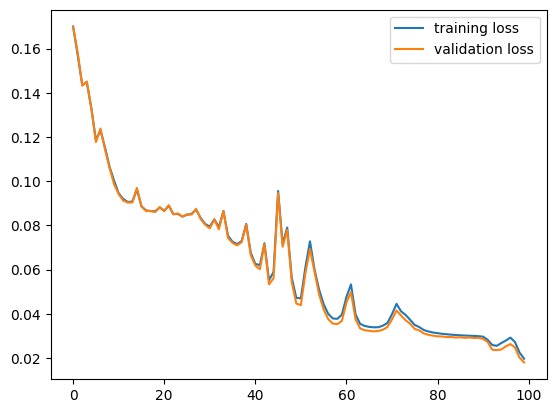

In [ ]:
model3 = Model3(196, 20)
training_loss, validation_loss = train_model_logit(model3, epochs=100)

plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()


In [ ]:
# test mse
test_X = mnist.test_data
test_y = mnist.test_labels
test_y = F.one_hot(test_y, num_classes=10).float()

test_y_pred = model3(test_X.float())
test_loss = F.mse_loss(test_y_pred, test_y)
test_acc = (test_y_pred.argmax(dim=1) == test_y.argmax(dim=1)).float().mean()

print(test_loss, test_acc)

tensor(0.0284, grad_fn=<MseLossBackward0>) tensor(0.8287)


## 3 b).

While the training loss can be unstable sometimes, we do see the training and validation loss closely accompany each other, indicating no overfitting; and we do see the decreasing trend of training loss over longer iterations. 

The testing mse of our model is 0.0284, and an test accuracy is 0.8287.

# Question 4

## 4 a).
In addition to the structure from the previous question, I employed a skip connection between output of A layer and output of the relu activation, this will avoid the dead neuron problem brought by relu activation. I also employed layer-norm following the output of layer A to further stabelize training. As a result, we do see a much smoother training curve, allowing us to train for more epochs without worrying about unstable results or overfitting.

In [ ]:
class Model4(nn.Module):

    def __init__(self, d1, d2):
        super(Model4, self).__init__()
        self.input = nn.Flatten()
        self.A = nn.Linear(28*28, d1, bias=True)
        self.B = nn.Linear(d1, d2, bias=False)
        self.W = nn.Linear(d2, 10, bias=True)

    def forward(self, x):
        x = self.input(x)
        x = self.A(x)
        x = F.layer_norm(x, x.shape)
        z = F.relu(x) + x
        z = self.B(z) 
        # layer norm
        z = F.layer_norm(z, z.shape)
        y = self.W(z)
        y = F.softmax(y, dim=1)
        return y

Training: 100%|██████████| 781500/781500 [06:46<00:00, 1921.55it/s]


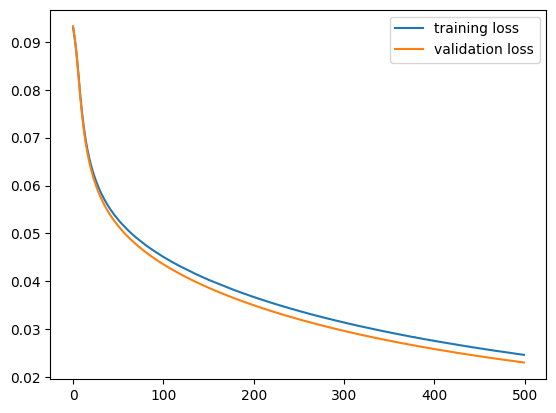

In [ ]:
model4 = Model4(196, 20)
training_loss, validation_loss = train_model_logit(model4, epochs=500)

plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()

In [ ]:
# test mse

test_X = mnist.test_data
test_y = mnist.test_labels
test_y = F.one_hot(test_y, num_classes=10).float()

test_y_pred = model4(test_X.float())
test_loss = F.mse_loss(test_y_pred, test_y)
test_acc = (test_y_pred.argmax(dim=1) == test_y.argmax(dim=1)).float().mean()

print(test_loss, test_acc)

tensor(0.0244, grad_fn=<MseLossBackward0>) tensor(0.8906)


## 4 b).

As a result of our design, we are able to achieve a testing mse of 0.0244 and a testing accuracy of 0.8906. This happens because the training process is more stable. 